In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

Starting path:/home/gregory_maruss/VESUVIUS_Challenge/jupyter notebooks
Current path:/home/gregory_maruss/VESUVIUS_Challenge


In [2]:
import torch
import monai
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
from Models.PVT2 import PyramidVisionTransformerV2, Up, OutConv
import torch.nn as nn
from functools import partial
import torchvision
import torch.nn.functional as F
from Models.Swin import SwinTransformer, SwinTransformerBlockV2, PatchMergingV2
import gc
from torch.utils.data import DataLoader, Dataset


2023-05-18 01:29:17,596 - Created a temporary directory at /tmp/tmps8hrgaql
2023-05-18 01:29:17,598 - Writing /tmp/tmps8hrgaql/_remote_module_non_scriptable.py


In [3]:
CHECKPOINT = 'logs/PVT_Unet_bce50_tver50_gamma1/last.ckpt'
SAMPLE_SUBMISSION = 'kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv'


PATCH_SIZE = 256
Z_DIM = 16
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
class PVT_w_UNet(nn.Module):
    def __init__(self, in_channels,  embed_dims=[ 64, 128, 256, 512], n_classes=1, ):
        super().__init__()
        
        self.embed_dims = embed_dims
        
        self.pvt = PyramidVisionTransformerV2(img_size = PATCH_SIZE,
                                  patch_size = 4,
                                  in_chans = Z_DIM,
                                  num_classes = 1,
                                  embed_dims = embed_dims,
                                num_heads=[1, 2, 4, 8],
                                  mlp_ratios=[8, 8, 4, 4],
                                  qkv_bias=True,
                                  qk_scale=None,
                                  drop_rate=0.,
                                attn_drop_rate=0.,
                                  drop_path_rate=0.1,
                                  norm_layer=partial(nn.LayerNorm, eps=1e-3),
                                #norm_layer=nn.LayerNorm,          
                                  depths=[3, 4, 6, 3],
                                  sr_ratios=[8, 4, 2, 1]
                                 ).to(DEVICE) 
        
        self.up1 = Up(self.embed_dims[-1], self.embed_dims[-2])
        self.up2 = Up(self.embed_dims[-2], self.embed_dims[-3])
        self.up3 = Up(self.embed_dims[-3], self.embed_dims[-4])
        self.up4 = Up(self.embed_dims[-4], in_channels, last_layer = True)
        
        self.out_conv = OutConv(in_channels,n_classes)
        

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.pvt(x)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.out_conv(x)
        
        
        return logits












In [5]:

class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.5
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'test' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    test_fragment_ids = ['a','b']
    
    

    
    
    batch_size = 8
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = PVT_w_UNet(in_channels = z_dim).to(DEVICE) 
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 192// batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 1e-7
    t_max = 80
    max_epochs = 120
    weight_decay =  0.0001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

In [6]:
lit_model = Lit_Model(cfg=CFG)

lit_model = lit_model.load_from_checkpoint(CHECKPOINT, cfg=CFG,).to(CFG.device)

lit_model.eval()

Lit_Model(
  (metrics): ModuleDict(
    (train_metrics): MetricCollection(
      (dice): Dice(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (dice): Dice(),
      prefix=val_
    )
  )
  (model): PVT_w_UNet(
    (pvt): PyramidVisionTransformerV2(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(16, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,), eps=0.001, elementwise_affine=True)
          (attn): Attention(
            (q): Linear(in_features=64, out_features=64, bias=True)
            (kv): Linear(in_features=64, out_features=128, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=64, out_features=64, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (sr): Conv2d(64, 64, kernel_size=(8, 8), stride=

In [7]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.patch_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.patch_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.patch_size
            x2 = x1 + CFG.patch_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=CFG.on_gpu, drop_last=False)
    
    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(
        [
        A.Resize(CFG.patch_size, CFG.patch_size),
        A.Normalize(
            mean=[0] * CFG.z_dim,
            std=[1] * CFG.z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
    )

def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.patch_size - image.shape[0] % CFG.patch_size)
        pad1 = (CFG.patch_size - image.shape[1] % CFG.patch_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image
    
    
    
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

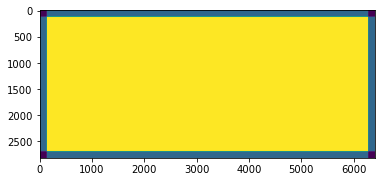

mask_count_min: 1.0


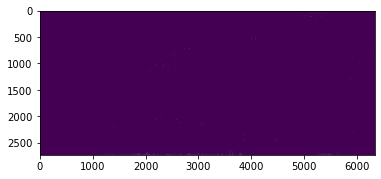

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

In [ ]:
THRESHOLD =0.5
results = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(CFG.device)
    mask_count = torch.zeros(binary_mask.shape).to(CFG.device)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            y_preds = lit_model(images)
            y_preds = torch.sigmoid(y_preds)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    
    results.append( inklabels_rle)
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
